# Import necessary modules

In [1]:
%pip install -U -q neurograd["all"]
%pip install -U -q cupy-cuda12x
# %pip install -q scalene==1.5.20
# %reload_ext scalene
import neurograd as ng
import os
import numpy as np
import gzip
import urllib.request

try:
    import cupy as cp
    # Clear all device memory
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    cp.cuda.runtime.deviceSynchronize()
except ImportError:
    print("[INFO] CuPy not found – using NumPy (CPU) for the demo.")
    import numpy as cp

from matplotlib import pyplot as plt
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 94.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 MB 15.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


# Prepare tiny ImageNet

In [2]:
# ================================================
# Tiny-ImageNet-200: download, extract, restructure,
# map WNIDs to words, then use ImageFolder + DataLoader
# ================================================
import os, zipfile, urllib.request, shutil
from pathlib import Path
import neurograd
import neurograd as ng
from neurograd import Tensor, xp
from neurograd.utils.data import ImageFolder, DataLoader
import albumentations as A
import cv2

# -------- config --------
DATA_DIR = Path("./data")
ZIP_PATH = DATA_DIR / "tiny-imagenet-200.zip"
ROOT     = DATA_DIR / "tiny-imagenet-200"
TRAIN    = ROOT / "train"
VAL      = ROOT / "val"
VAL_IMG  = VAL / "images"
VAL_ANN  = VAL / "val_annotations.txt"
WORDS_TXT = ROOT / "words.txt"

URLS = [
    "http://cs231n.stanford.edu/tiny-imagenet-200.zip",
    "https://tiny-imagenet.s3.amazonaws.com/tiny-imagenet-200.zip",  # fallback
]

BATCH_SIZE   = 240
IMG_SHAPE    = (227, 227)
IMG_MODE     = "RGB"
USE_ONE_HOT  = True
NUM_CLASSES  = 200

# -------- helpers --------
def download_with_fallback(urls, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists() and dst.stat().st_size > 0:
        print(f"[SKIP] {dst.name} already present.")
        return
    for url in urls:
        try:
            print(f"[DOWNLOAD] {url}")
            urllib.request.urlretrieve(url, dst)
            print("[OK] Downloaded.")
            return
        except Exception as e:
            print(f"[WARN] Failed: {e}")
    raise RuntimeError("All downloads failed.")

def extract_zip(zip_path: Path, out_dir: Path):
    if out_dir.exists() and (out_dir / "train").exists() and (out_dir / "val").exists():
        print("[SKIP] Already extracted.")
        return
    print(f"[EXTRACT] {zip_path} -> {out_dir.parent}")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir.parent)
    print("[OK] Extracted.")

def clean_unwanted_directories(base_dir: Path):
    """Remove unwanted directories like .ipynb_checkpoints, .DS_Store, etc."""
    unwanted_patterns = ['.ipynb_checkpoints', '.DS_Store', '__pycache__', 'Thumbs.db']
    removed_count = 0
    
    for pattern in unwanted_patterns:
        for path in base_dir.glob(f"**/{pattern}"):
            if path.is_dir():
                shutil.rmtree(path)
                print(f"[CLEAN] Removed directory: {path}")
                removed_count += 1
            elif path.is_file():
                path.unlink()
                print(f"[CLEAN] Removed file: {path}")
                removed_count += 1
    
    if removed_count > 0:
        print(f"[OK] Cleaned {removed_count} unwanted items.")
    return removed_count

def is_valid_wnid(directory_name: str):
    """Check if directory name looks like a valid WNID (starts with 'n' followed by 8 digits)"""
    parts = directory_name.split('_')
    wnid = parts[0]
    return (len(wnid) == 9 and 
            wnid.startswith('n') and 
            wnid[1:].isdigit())

def restructure_train_inplace(train_dir: Path):
    # First clean unwanted directories
    clean_unwanted_directories(train_dir)
    
    valid_dirs = []
    for wnid in [p for p in train_dir.iterdir() if p.is_dir()]:
        if is_valid_wnid(wnid.name):
            valid_dirs.append(wnid)
            images_dir = wnid / "images"
            if images_dir.is_dir():
                for img in images_dir.iterdir():
                    if img.is_file():
                        os.replace(img, wnid / img.name)
                try:
                    images_dir.rmdir()
                except OSError:
                    pass
        else:
            print(f"[WARN] Removing invalid directory: {wnid.name}")
            if wnid.is_dir():
                shutil.rmtree(wnid)
            else:
                wnid.unlink()
    
    print(f"[TRAIN] Restructured. Found {len(valid_dirs)} valid class directories.")

def restructure_val_inplace(val_dir: Path):
    # First clean unwanted directories
    clean_unwanted_directories(val_dir)
    
    if not (val_dir / "images").exists():
        print("[VAL] Already restructured.")
        return
    
    mapping = {}
    with open(val_dir / "val_annotations.txt", "r") as f:
        for line in f:
            fname, wnid = line.strip().split("\t")[:2]
            if is_valid_wnid(wnid):
                mapping[fname] = wnid
    
    valid_classes = set()
    for fname, wnid in mapping.items():
        src = val_dir / "images" / fname
        if src.exists():
            dst_dir = val_dir / wnid
            dst_dir.mkdir(parents=True, exist_ok=True)
            os.replace(src, dst_dir / fname)
            valid_classes.add(wnid)
    
    try:
        (val_dir / "images").rmdir()
    except OSError:
        pass
    
    print(f"[VAL] Restructured. Found {len(valid_classes)} valid class directories.")

def load_wnid_to_words(words_file: Path):
    wnid_to_words = {}
    if not words_file.exists():
        print(f"[WARN] {words_file} not found. Using WNIDs as class names.")
        return wnid_to_words
    with open(words_file, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                wnid = parts[0]
                # Only include valid WNIDs that are actually used in Tiny-ImageNet-200
                if is_valid_wnid(wnid):
                    words = parts[1].split(",")[0].strip()
                    wnid_to_words[wnid] = words
    print(f"[OK] Loaded {len(wnid_to_words)} WNID->words mappings.")
    return wnid_to_words

def rename_directories_to_words(base_dir: Path, wnid_to_words: dict):
    if not wnid_to_words:
        print("[SKIP] No WNID mappings available.")
        return {}
    
    wnid_to_new_name, renamed_count = {}, 0
    valid_dirs = [p for p in base_dir.iterdir() if p.is_dir() and is_valid_wnid(p.name)]
    
    for wnid_dir in valid_dirs:
        wnid = wnid_dir.name.split('_')[0]  # Get the WNID part
        if wnid in wnid_to_words:
            clean_word = "".join(c if c.isalnum() else "_" for c in wnid_to_words[wnid]).strip("_")
            new_name = f"{wnid}_{clean_word}"
            new_dir = base_dir / new_name
            if not wnid_dir.name.endswith(f"_{clean_word}"):
                try:
                    wnid_dir.rename(new_dir)
                    wnid_to_new_name[wnid] = new_name
                    renamed_count += 1
                except OSError as e:
                    print(f"[WARN] Could not rename {wnid}: {e}")
                    wnid_to_new_name[wnid] = wnid_dir.name
            else:
                wnid_to_new_name[wnid] = wnid_dir.name
        else:
            wnid_to_new_name[wnid] = wnid_dir.name
    
    print(f"[OK] Renamed {renamed_count} directories with word labels.")
    return wnid_to_new_name

def verify_class_count(base_dir: Path, expected_count: int = NUM_CLASSES):
    """Verify that we have exactly the expected number of classes"""
    valid_dirs = [p for p in base_dir.iterdir() if p.is_dir() and is_valid_wnid(p.name)]
    actual_count = len(valid_dirs)
    
    print(f"[VERIFY] {base_dir.name}: Expected {expected_count} classes, found {actual_count}")
    
    if actual_count != expected_count:
        print(f"[ERROR] Class count mismatch! Expected {expected_count}, got {actual_count}")
        print("Valid class directories found:")
        for i, d in enumerate(sorted(valid_dirs)[:10]):
            print(f"  {i+1}: {d.name}")
        if len(valid_dirs) > 10:
            print(f"  ... and {len(valid_dirs) - 10} more")
        return False
    return True

# -------- run prep --------
download_with_fallback(URLS, ZIP_PATH)
extract_zip(ZIP_PATH, ROOT)
restructure_train_inplace(TRAIN)
restructure_val_inplace(VAL)

# Verify class counts before proceeding
train_valid = verify_class_count(TRAIN, NUM_CLASSES)
val_valid = verify_class_count(VAL, NUM_CLASSES)

if not (train_valid and val_valid):
    print("[ERROR] Invalid class structure detected. Please check your data.")
    exit(1)

# -------- load wnid mappings and rename directories --------
wnid_to_words = load_wnid_to_words(WORDS_TXT)
train_mapping = rename_directories_to_words(TRAIN, wnid_to_words)
val_mapping = rename_directories_to_words(VAL, wnid_to_words)

# -------- one-hot transform --------
def to_one_hot(idx: int, num_classes: int = NUM_CLASSES):
    v = xp.zeros((num_classes,), dtype=xp.float32)
    v[idx] = 1.0
    return v

target_tf = (lambda i: to_one_hot(i, NUM_CLASSES)) if USE_ONE_HOT else None
target_dtype = xp.float32 if USE_ONE_HOT else xp.int64

# -------- augmentations/datasets/loaders --------
H, W = IMG_SHAPE
# good #
train_aug = A.Compose([ 
    # geometry
    A.RandomResizedCrop(
        size=IMG_SHAPE,                   # (H, W)
        scale=(0.5, 1.0),
        ratio=(3/4, 4/3),
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent=(0.08, 0.08),
        scale=(0.85, 1.15),
        rotate=(-15, 15),
        shear=(-8, 8),
        fit_output=False,
        fill=0,                           # <- was cval
        p=0.7
    ),

    # photometric
    A.OneOf([
        A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05, p=1.0),
        A.HueSaturationValue(hue_shift_limit=12, sat_shift_limit=20, val_shift_limit=12, p=1.0),
    ], p=0.9),
    A.RandomGamma(gamma_limit=(70, 130), p=0.2),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.2),

    # blur/noise (light)
    A.OneOf([
        A.MotionBlur(blur_limit=5, p=1.0),
        A.MedianBlur(blur_limit=3, p=1.0),
        A.GaussNoise(std_range=(0.05, 0.15), mean_range=(0.0, 0.0), p=1.0),  # <- was var_limit/mean
    ], p=0.25),

    # occlusion
    A.CoarseDropout(
        num_holes_range=(1, 3),                     # <- was min_holes/max_holes
        hole_height_range=(0.06, 0.18),             # <- was min_height/max_height
        hole_width_range=(0.06, 0.18),              # <- was min_width/max_width
        fill=0,                                     # <- was fill_value
        p=0.7
    ),
])


train_ds = ImageFolder(
    root=str(TRAIN),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=True,
    img_transform=train_aug,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

val_ds = ImageFolder(
    root=str(VAL),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=True,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
)

# -------- sanity check --------
Xb, yb = next(iter(train_loader))
print("\nTiny-ImageNet batch:")
print("X:", Xb.shape, Xb.dtype)
print("y:", yb.shape, yb.dtype)

# Show class folder names (should now be exactly 200)
class_folders = sorted([d for d in os.listdir(TRAIN) if os.path.isdir(os.path.join(TRAIN, d)) and is_valid_wnid(d)])
print(f"\nTotal valid class folders: {len(class_folders)}")
print("Sample class folder names:", class_folders[:10])

# Show relevant WNID mappings (only for classes that exist in our dataset)
if wnid_to_words:
    relevant_mappings = {wnid: word for wnid, word in wnid_to_words.items() 
                        if any(folder.startswith(wnid) for folder in class_folders)}
    print(f"\nRelevant WNID->words mappings ({len(relevant_mappings)}):")
    for i, (wnid, word) in enumerate(list(relevant_mappings.items())[:10]):
        print(f"  {wnid}: {word}")

TARGET_MAPPING = train_ds.target_mapping
TARGET_INV_MAPPING = {v: k for k, v in TARGET_MAPPING.items()}
TARGET_NAMES = train_ds.target_names

print(f"\nDataset verification:")
print(f"Total classes in dataset: {train_ds.num_classes}")
print(f"Expected classes: {NUM_CLASSES}")
print(f"Match: {'good' if train_ds.num_classes == NUM_CLASSES else 'not good'}")

if train_ds.num_classes == NUM_CLASSES:
    print("First 10 class names:", TARGET_NAMES[:10])
else:
    print("[ERROR] Class count still doesn't match!")
    print("All class names found:", TARGET_NAMES)

[SKIP] tiny-imagenet-200.zip already present.
[SKIP] Already extracted.
[TRAIN] Restructured. Found 200 valid class directories.
[VAL] Already restructured.
[VERIFY] train: Expected 200 classes, found 200
[VERIFY] val: Expected 200 classes, found 200
[OK] Loaded 82115 WNID->words mappings.
[OK] Renamed 0 directories with word labels.
[OK] Renamed 0 directories with word labels.

Tiny-ImageNet batch:
X: (240, 3, 227, 227) <class 'numpy.float32'>
y: (240, 200) <class 'numpy.float32'>

Total valid class folders: 200
Sample class folder names: ['n01443537_goldfish', 'n01629819_European_fire_salamander', 'n01641577_bullfrog', 'n01644900_tailed_frog', 'n01698640_American_alligator', 'n01742172_boa_constrictor', 'n01768244_trilobite', 'n01770393_scorpion', 'n01774384_black_widow', 'n01774750_tarantula']

Relevant WNID->words mappings (200):
  n01443537: goldfish
  n01629819: European fire salamander
  n01641577: bullfrog
  n01644900: tailed frog
  n01698640: American alligator
  n01742172: bo

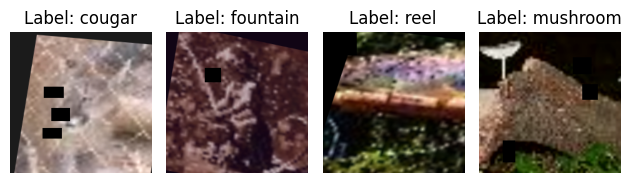

In [3]:
# Plot 4 random images

indices = range(len(train_ds))
chosen = random.sample(indices, 4)

for i, idx in enumerate(chosen, 1):
  plt.subplot(1, 4, i)
  img, label = train_ds[idx]
  img = img.data.transpose(1, 2, 0).get()
  label = TARGET_INV_MAPPING.get(label.data.argmax().item()).split("_")[1]
  plt.axis("off")
  plt.imshow(img)
  plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

# Model architecture, optimizer and losses

In [4]:
try:
    checkpoint = ng.load("checkpoint.pkl")
except:
    checkpoint = None

In [6]:
from neurograd.nn.layers import Conv2D, MaxPool2D, Flatten, Linear, Sequential, Dropout

model = Sequential(
    Conv2D(3, 96, 11, strides=4, activation="relu", batch_normalization=True),
    MaxPool2D(3, strides=2),
    Conv2D(96, 256, 5, padding="same", activation="relu", batch_normalization=True),
    MaxPool2D(3, strides=2),
    Conv2D(256, 384, 3, padding="same", activation="relu", batch_normalization=True),
    Conv2D(384, 384, 3, padding="same", activation="relu", batch_normalization=True),
    Conv2D(384, 256, 3, padding="same", activation="relu", batch_normalization=True),
    MaxPool2D(3, strides=2),
    Flatten(),
    Linear(9216, 4096, activation="relu", batch_normalization=True, dropout=0.5),
    Linear(4096, 4096, activation="relu", batch_normalization=True, dropout=0.5),
    Linear(4096, NUM_CLASSES)
)

if checkpoint:
    model.load_state_dict(checkpoint["model"])

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

layer_0.kernels (96, 3, 11, 11)
layer_0.bias (1, 96, 1, 1)
layer_0.batch_norm.mean_scaler (1, 96, 1, 1)
layer_0.batch_norm.std_scaler (1, 96, 1, 1)
layer_2.kernels (256, 96, 5, 5)
layer_2.bias (1, 256, 1, 1)
layer_2.batch_norm.mean_scaler (1, 256, 1, 1)
layer_2.batch_norm.std_scaler (1, 256, 1, 1)
layer_4.kernels (384, 256, 3, 3)
layer_4.bias (1, 384, 1, 1)
layer_4.batch_norm.mean_scaler (1, 384, 1, 1)
layer_4.batch_norm.std_scaler (1, 384, 1, 1)
layer_5.kernels (384, 384, 3, 3)
layer_5.bias (1, 384, 1, 1)
layer_5.batch_norm.mean_scaler (1, 384, 1, 1)
layer_5.batch_norm.std_scaler (1, 384, 1, 1)
layer_6.kernels (256, 384, 3, 3)
layer_6.bias (1, 256, 1, 1)
layer_6.batch_norm.mean_scaler (1, 256, 1, 1)
layer_6.batch_norm.std_scaler (1, 256, 1, 1)
layer_9.weight (9216, 4096)
layer_9.bias (4096,)
layer_9.batch_norm.mean_scaler (1, 4096)
layer_9.batch_norm.std_scaler (1, 4096)
layer_10.weight (4096, 4096)
layer_10.bias (4096,)
layer_10.batch_norm.mean_scaler (1, 4096)
layer_10.batch_norm.st

In [7]:
from neurograd.optim import Adam, SGD
from neurograd.nn.losses import CategoricalCrossEntropy
from neurograd.nn.metrics import accuracy_score

optimizer = Adam(model.named_parameters(), lr=1e-3)
if checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer"])
loss_fn = CategoricalCrossEntropy(from_logits=True)

# Training (mixed precision)

In [ ]:
import neurograd as ng
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 200
BATCH_SIZE = train_loader.batch_size
# ========================

scaler = GradScaler() if USE_AMP else None
best_val_acc = float("-inf")  # track best accuracy
# If you prefer lowest loss instead, init with float("inf")

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch: {epoch} / {EPOCHS}:")
    train_losses, train_acc = [], []
    test_losses, test_acc = [], []

    # ===== Training loop =====
    model.train()
    for (X_train, y_train) in tqdm(train_loader):
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            train_losses.append(loss.data)
            optimizer.zero_grad()
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
            train_acc.append(acc)

    # ===== Validation loop =====
    model.eval()
    for (X_test, y_test) in val_loader:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_test)
            loss = loss_fn(y_test, y_pred)
            acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
            test_losses.append(loss.data)
            test_acc.append(acc)

    # Convert lists to arrays before mean
    train_losses = cp.asarray(train_losses)
    train_acc = cp.asarray(train_acc)
    test_losses = cp.asarray(test_losses)
    test_acc = cp.asarray(test_acc)

    mean_train_loss = cp.nanmean(train_losses)
    mean_train_acc = cp.mean(train_acc)
    mean_test_loss = cp.nanmean(test_losses)
    mean_test_acc = cp.mean(test_acc)

    print(
        f"Train loss: {mean_train_loss:.4f}, "
        f"Train acc: {mean_train_acc:.4f}, "
        f"Test loss: {mean_test_loss:.4f}, "
        f"Test acc: {mean_test_acc:.4f}"
    )

    # ===== Save only if validation improved =====
    if mean_test_acc > best_val_acc:   # change this to < if using loss
        best_val_acc = mean_test_acc
        ng.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "val_acc": float(best_val_acc),
            "val_loss": float(mean_test_loss),
        }, "checkpoint.pkl")
        print(f"✅ Saved checkpoint (val acc improved to {best_val_acc:.4f})")


Epoch: 1 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 5.3526, Train acc: 0.0292, Test loss: 4.5802, Test acc: 0.0716
✅ Saved checkpoint (val acc improved to 0.0716)
Epoch: 2 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.7678, Train acc: 0.0644, Test loss: 4.3062, Test acc: 0.1047
✅ Saved checkpoint (val acc improved to 0.1047)
Epoch: 3 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.4923, Train acc: 0.0874, Test loss: 4.6832, Test acc: 0.0709
Epoch: 4 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.3457, Train acc: 0.1009, Test loss: 4.3076, Test acc: 0.1011
Epoch: 5 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.2608, Train acc: 0.1128, Test loss: 4.4084, Test acc: 0.0934
Epoch: 6 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.2182, Train acc: 0.1187, Test loss: 4.4970, Test acc: 0.0881
Epoch: 7 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.1285, Train acc: 0.1295, Test loss: 4.3646, Test acc: 0.1027
Epoch: 8 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.0776, Train acc: 0.1394, Test loss: 3.8582, Test acc: 0.1682
✅ Saved checkpoint (val acc improved to 0.1682)
Epoch: 9 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.0737, Train acc: 0.1384, Test loss: 4.5271, Test acc: 0.1027
Epoch: 10 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 4.0318, Train acc: 0.1453, Test loss: 4.7439, Test acc: 0.0794
Epoch: 11 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.9501, Train acc: 0.1563, Test loss: 3.9751, Test acc: 0.1533
Epoch: 12 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.9101, Train acc: 0.1615, Test loss: 4.1695, Test acc: 0.1346
Epoch: 13 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.8900, Train acc: 0.1641, Test loss: 3.7419, Test acc: 0.1870
✅ Saved checkpoint (val acc improved to 0.1870)
Epoch: 14 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.8828, Train acc: 0.1683, Test loss: 4.3859, Test acc: 0.1303
Epoch: 15 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.8338, Train acc: 0.1755, Test loss: 4.7237, Test acc: 0.0951
Epoch: 16 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.7970, Train acc: 0.1810, Test loss: 3.9755, Test acc: 0.1557
Epoch: 17 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.7508, Train acc: 0.1860, Test loss: 3.9153, Test acc: 0.1670
Epoch: 18 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.7148, Train acc: 0.1936, Test loss: 4.2896, Test acc: 0.1410
Epoch: 19 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.6773, Train acc: 0.1965, Test loss: 4.0611, Test acc: 0.1619
Epoch: 20 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.6541, Train acc: 0.2020, Test loss: 3.4111, Test acc: 0.2420
✅ Saved checkpoint (val acc improved to 0.2420)
Epoch: 21 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.6054, Train acc: 0.2102, Test loss: 3.6368, Test acc: 0.2128
Epoch: 22 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.5780, Train acc: 0.2144, Test loss: 3.3903, Test acc: 0.2489
✅ Saved checkpoint (val acc improved to 0.2489)
Epoch: 23 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.5292, Train acc: 0.2223, Test loss: 4.7660, Test acc: 0.1214
Epoch: 24 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.4838, Train acc: 0.2280, Test loss: 3.3560, Test acc: 0.2578
✅ Saved checkpoint (val acc improved to 0.2578)
Epoch: 25 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.4477, Train acc: 0.2329, Test loss: 3.6980, Test acc: 0.2102
Epoch: 26 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.4105, Train acc: 0.2403, Test loss: 3.3794, Test acc: 0.2526
Epoch: 27 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.3821, Train acc: 0.2456, Test loss: 3.6615, Test acc: 0.2133
Epoch: 28 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.3604, Train acc: 0.2480, Test loss: 3.4397, Test acc: 0.2411
Epoch: 29 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.3253, Train acc: 0.2548, Test loss: 3.2972, Test acc: 0.2698
✅ Saved checkpoint (val acc improved to 0.2698)
Epoch: 30 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.2728, Train acc: 0.2646, Test loss: 3.2681, Test acc: 0.2689
Epoch: 31 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.2372, Train acc: 0.2686, Test loss: 3.0471, Test acc: 0.3112
✅ Saved checkpoint (val acc improved to 0.3112)
Epoch: 32 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.2016, Train acc: 0.2736, Test loss: 3.0621, Test acc: 0.3061
Epoch: 33 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.1607, Train acc: 0.2802, Test loss: 3.0185, Test acc: 0.3167
✅ Saved checkpoint (val acc improved to 0.3167)
Epoch: 34 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.1335, Train acc: 0.2857, Test loss: 3.1549, Test acc: 0.3016
Epoch: 35 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.0845, Train acc: 0.2936, Test loss: 3.0366, Test acc: 0.3127
Epoch: 36 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.0621, Train acc: 0.2971, Test loss: 3.1918, Test acc: 0.2828
Epoch: 37 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.0354, Train acc: 0.3020, Test loss: 3.0151, Test acc: 0.3170
✅ Saved checkpoint (val acc improved to 0.3170)
Epoch: 38 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 3.0164, Train acc: 0.3043, Test loss: 2.9104, Test acc: 0.3343
✅ Saved checkpoint (val acc improved to 0.3343)
Epoch: 39 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: 2.9689, Train acc: 0.1195, Test loss: nan, Test acc: 0.0050
Epoch: 40 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: nan, Train acc: 0.0050, Test loss: nan, Test acc: 0.0050
Epoch: 41 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: nan, Train acc: 0.0050, Test loss: nan, Test acc: 0.0050
Epoch: 42 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

Train loss: nan, Train acc: 0.0050, Test loss: nan, Test acc: 0.0050
Epoch: 43 / 200:


  0%|          | 0/417 [00:00<?, ?it/s]

# Visualize model predictions

In [ ]:
# Plot 4 random predictions from validation set
X, y = random.choice(val_loader)

with ng.autocast():
    y_pred = model(X)

indices = range(len(X))
chosen = random.sample(indices, 4)

correct = 0
for i, idx in enumerate(chosen, 1):
    plt.subplot(1, 4, i)
    img = X[idx].data.transpose(1, 2, 0).get()  # Convert CHW to HWC

    if USE_ONE_HOT:
        label = y[idx].data.argmax(-1).item()
        pred = y_pred[idx].data.argmax(-1).item()
    else:
        label = y[idx].data.item()
        pred = y_pred[idx].data.argmax(-1).item()

    correct += (label == pred)

    # Get human-readable class names
    label_name = TARGET_NAMES[label] if label < len(TARGET_NAMES) else str(label)
    pred_name = TARGET_NAMES[pred] if pred < len(TARGET_NAMES) else str(pred)

    plt.axis("off")
    plt.imshow(img)
    plt.title(f"Label: {label_name}\nPred: {pred_name}")

plt.tight_layout()
plt.show()
print(f"Guessed {correct} / 4")